In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
from pymatreader import read_mat
import IPython
from pathlib import Path
from utilities import savefig, FKFit, FitInput, FitResult, perform_fit, perform_fit_rounds, FK_fit
from iminuit import Minuit
from iminuit.cost import LeastSquares, BinnedNLL
from scipy.special import softmax
from scipy.stats import chi2
from scipy.optimize import curve_fit
from dataclasses import dataclass

In [2]:
NB_NAME = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).stem

In [3]:
# "VoltPowerScan_SNSPD_GaAs_SiO2___RT_scan_TMTE_20250114-153142_CTL_CW_0p02uW_200uW_0V_-5V.mat"

# DATAPATH = os.path.join(os.path.abspath(""), "data", NB_NAME, "VoltPowerScan_SNSPD_GaAs_SiO2___RT_scan_TMTE_20250114-153142_CTL_CW_0p02uW_200uW_0V_-5V.mat")
# data = read_mat(DATAPATH)["Data"]
DATAPATH = os.path.join(os.path.abspath(""), "data", NB_NAME)

fnames = os.listdir(DATAPATH)
fnames = [os.path.join(DATAPATH, fname) for fname in fnames]
data_dict = {}

for fname in fnames:
    data = read_mat(fname)["Data"]
    resistance = int(data["Resistance"])
    if (
        Path(fname).stem
        == "VoltPowerScan_SNSPD_GaAs_SiO2___RT_scan_TMTE_20250114-153142_CTL_CW_0p02uW_200uW_0V_-5V"
    ):
        data = {
            "counts": data["MeasureCounts"][:, :-6:5],
            "current": data["MeasureCurrent"][:, :-6:5] * 1e6,
            "M_power": data["MeasuredPower"] * 1e6,
        }
    else:
        voltagelist = data["VoltageList"]
        powerlist = data["PowerList"] * 1e6
        data = {
            "counts": data["MeasureCounts"],
            "current": data["MeasureCurrent"] * 1e6,
            "M_power": data["MeasuredPower"] * 1e6,
        }
    data_dict[resistance] = data

resistances = sorted(list(data_dict.keys()))

/home/ali/miniconda3/envs/university/lib/python3.11/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


In [4]:
def plot_2d_maps(data_dict, powerlist, voltagelist, resistances):
    for resistance in resistances:
        print(f"DATA FOR RESISTANCE: {resistance:,}")
        fig, (ax, ax1) = plt.subplots(1, 2, figsize=(11, 4))
        pcm = ax.contourf(voltagelist, powerlist, data_dict[resistance]["counts"], levels=len(voltagelist))
        cb = fig.colorbar(pcm, ax=ax, pad = 0.01)
        cb.set_label(r"Counts", fontsize=14)
        ax.set_xlabel(r"Voltage [$V$]", fontsize=14)
        ax.set_ylabel(r"Power [$\mu W$]", fontsize=14)

        pcm = ax1.contourf(voltagelist, powerlist, np.abs(data_dict[resistance]["current"]), levels=len(voltagelist))
        cb = fig.colorbar(pcm, ax=ax1, pad = 0.01)
        cb.set_label(r"Current [$\mu W$]", fontsize=14)
        ax1.set_xlabel(r"Voltage [$V$]", fontsize=14)
        ax1.set_ylabel(r"Power [$\mu W$]", fontsize=14)
        plt.show()

DATA FOR RESISTANCE: 0


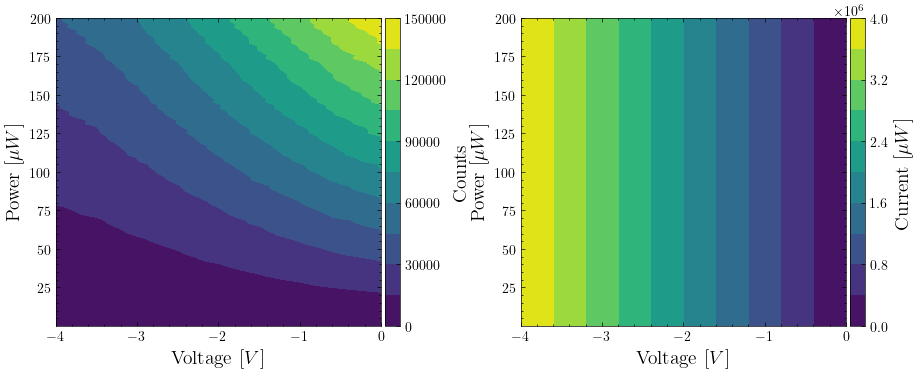

DATA FOR RESISTANCE: 97,500


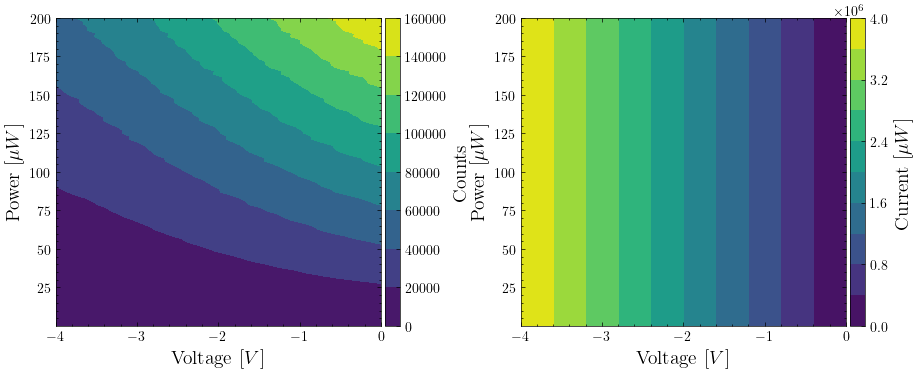

DATA FOR RESISTANCE: 325,300


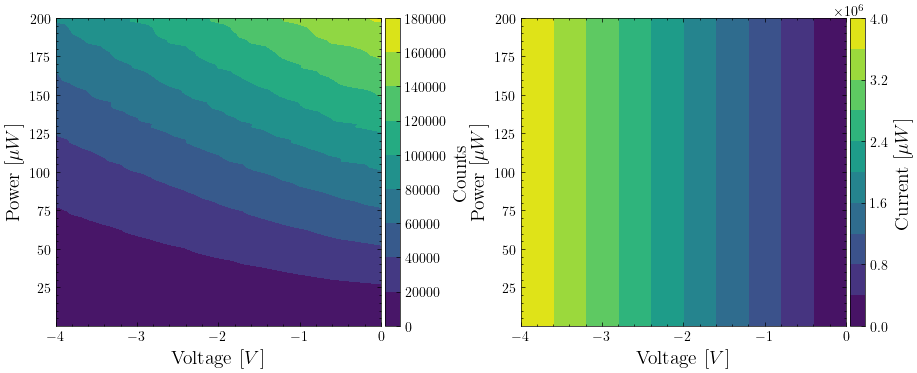

DATA FOR RESISTANCE: 552,000


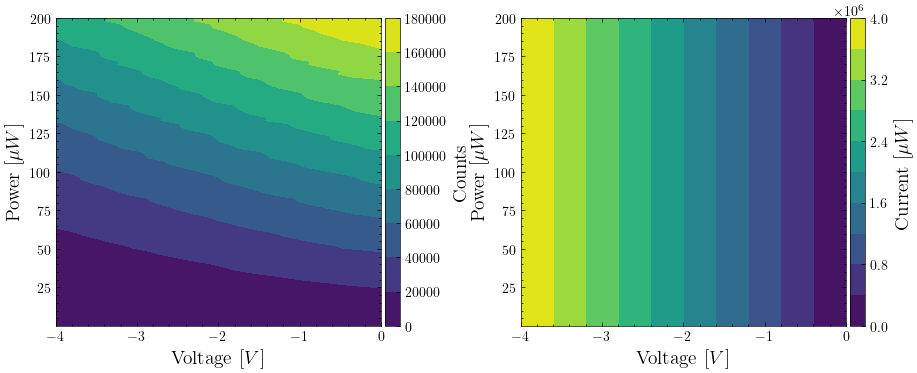

DATA FOR RESISTANCE: 677,000


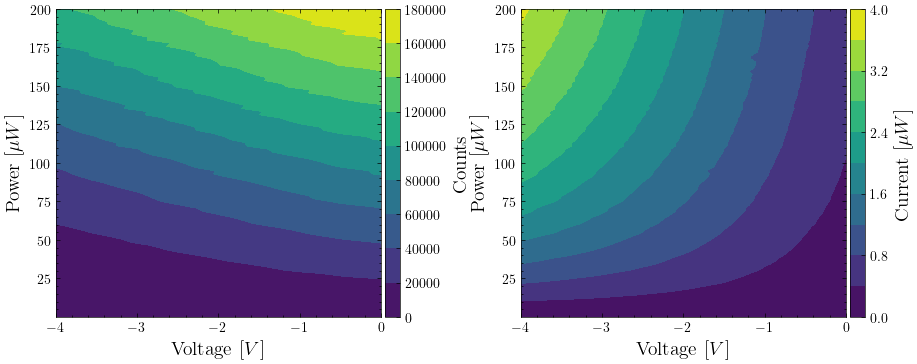

DATA FOR RESISTANCE: 807,000


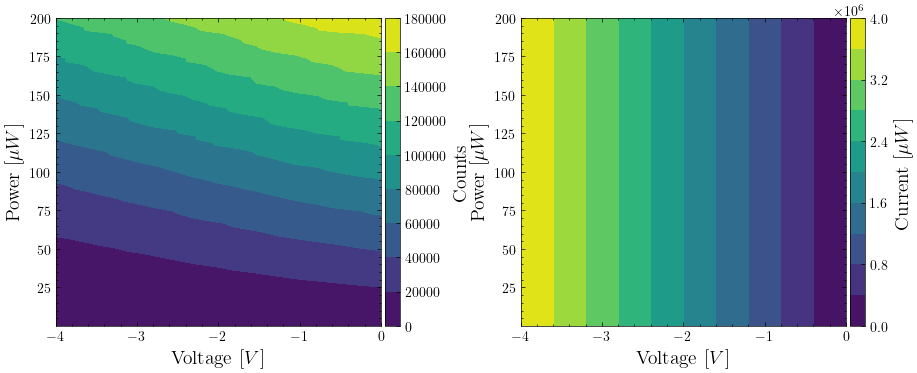

DATA FOR RESISTANCE: 1,000,000


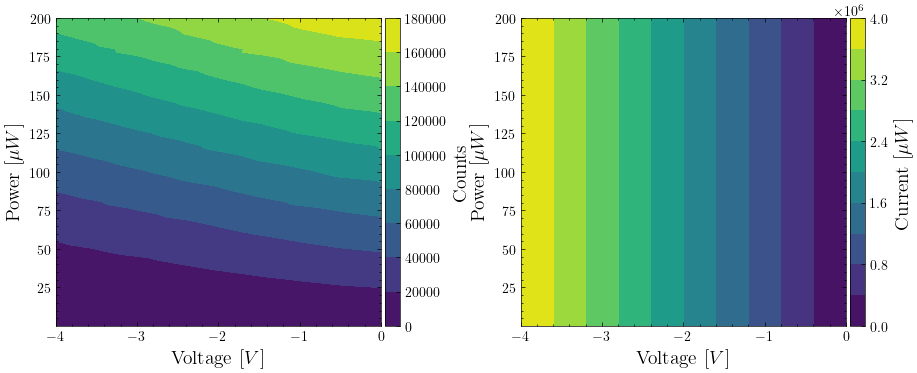

DATA FOR RESISTANCE: 3,012,000


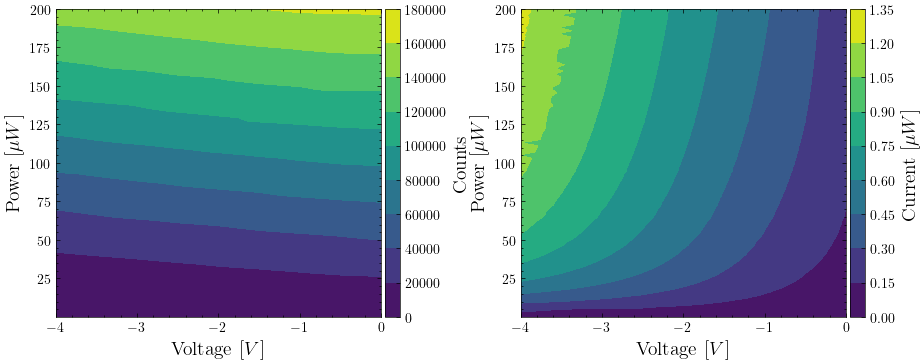

DATA FOR RESISTANCE: 10,000,000


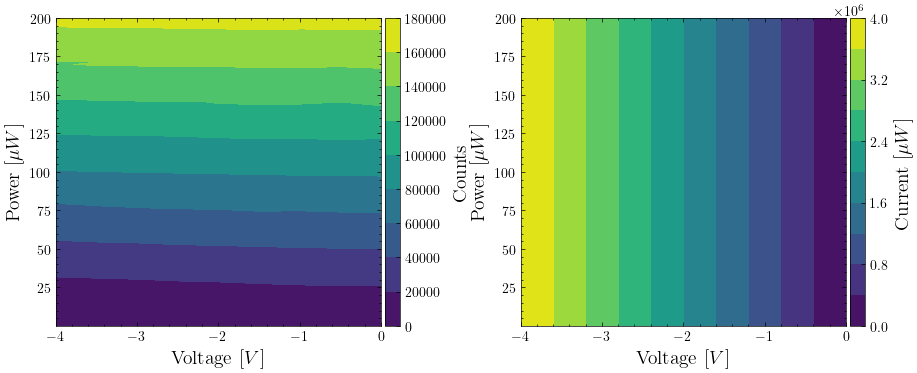

In [5]:
plot_2d_maps(data_dict, powerlist, voltagelist, resistances)

/tmp/ipykernel_474460/3075774126.py:34: RuntimeWarning: overflow encountered in exp
  return eta * (1 - np.exp(- g * (alpha + alpha_0)))


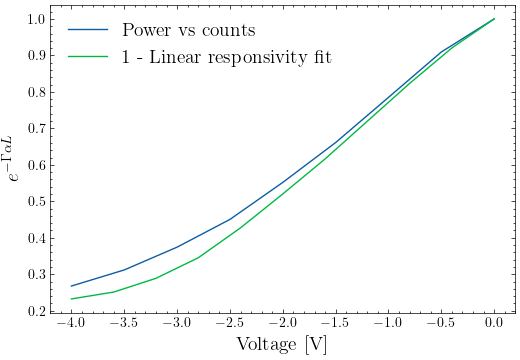

In [6]:
res_vals = np.array(
    [
        0.00246774,
        0.00331241,
        0.00434538,
        0.00544527,
        0.00654494,
        0.00756364,
        0.00855119,
        0.00942302,
        0.01002056,
        0.01042127,
        0.01062068,
    ]
)
res_voltages = np.array(
    [0.0, -0.4, -0.8, -1.2, -1.6, -2.0, -2.4, -2.8, -3.2, -3.6, -4.0]
)
fig, ax = plt.subplots(1, 1, figsize=(6,4))

power_num = 50
ax.plot(voltagelist, data_dict[0]["counts"][power_num] / np.max(data_dict[0]["counts"][power_num]), label=r"Power vs counts")
ax.plot(res_voltages, 1 - (res_vals - res_vals[0]) / np.max(res_vals), label=r"1 - Linear responsivity fit")
ax.set_xlabel("Voltage [V]", fontsize=14)
ax.set_ylabel(r"$e^{{-\Gamma \alpha L}}$", fontsize=14)
ax.legend(frameon=False, fontsize=14)

# epsilon is our responsivity
# epsilon = eta * (1 - e^(- g * alpha(V)))
# T = T_0 * e^(- g * alpha(V))

def linear1(V_d: np.ndarray, eta: float, g: float, alpha_0: float):
    alpha = FK_fit(931, 0, 298, V_d)
    return eta * (1 - np.exp(- g * (alpha + alpha_0)))

def linear2(V_d: np.ndarray, T_0: float, g: float):
    alpha = FK_fit(2.99792458e5 / 321.5, 0, 298, V_d)
    return T_0 * np.exp(- g * alpha)

lin1_fit_result = perform_fit(FitInput(res_voltages, res_vals, 1e-5, linear1, [0.01, 0.4, 50]))
lin2_fit_result = perform_fit(FitInput(voltagelist, data_dict[0]["counts"][power_num], np.sqrt(data_dict[0]["counts"][power_num]), linear2, [14000, 1.2e-3]))
voltage_lin = np.linspace(0, -4, 1000)

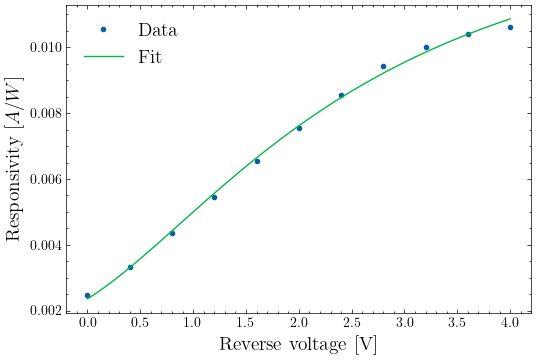

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
pars = lin1_fit_result.parameters
ax.plot(np.abs(res_voltages), res_vals, '.', label="Data")
ax.plot(np.abs(voltage_lin), linear1(voltage_lin, *lin1_fit_result.parameters), label="Fit")
ax.set_xlabel(r"Reverse voltage [V]", fontsize=14)
ax.set_ylabel(r"Responsivity [$A/W$]", fontsize=14)
ax.legend(frameon=False, fontsize=14)

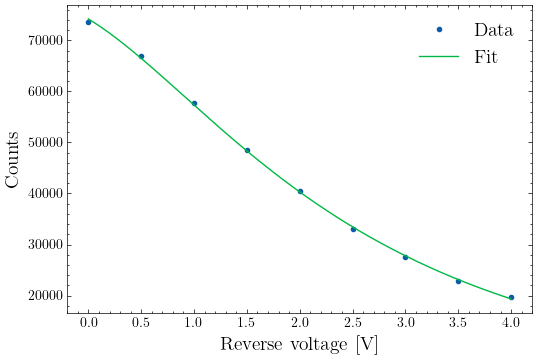

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(np.abs(voltagelist), data_dict[0]["counts"][power_num], '.', label="Data")
ax.plot(np.abs(voltage_lin), linear2(voltage_lin, *lin2_fit_result.parameters), label="Fit")
ax.set_xlabel(r"Reverse voltage [V]", fontsize=14)
ax.set_ylabel(r"Counts", fontsize=14)
ax.legend(frameon=False, fontsize=14)
ax.legend(fontsize=14)

In [9]:
print(f"eta from responsivity fit: {lin1_fit_result.parameters[0]}")

eta from responsivity fit: 0.014083862241627844


In [10]:
print(f"alpha_0 from responsivity fit: {lin1_fit_result.parameters[2]}")

alpha_0 from responsivity fit: 79.84115114586704


In [11]:
print(f"g=Gamma*L calculations:\nResponsivity fit: {lin1_fit_result.parameters[1]}\nTransmission_fit: {lin2_fit_result.parameters[1]}")

g=Gamma*L calculations:
Responsivity fit: 0.0014414279509820502
Transmission_fit: 0.0015566610020618394


In [12]:
gamma_lin1 = lin1_fit_result.parameters[1] / 3.5e-3
gamma_lin2 = lin2_fit_result.parameters[1] / 3.5e-3
print(f"Gamma calculations:\nResponsivity fit: {gamma_lin1}\nTransmission fit: {gamma_lin2}")

Gamma calculations:
Responsivity fit: 0.4118365574234429
Transmission fit: 0.44476028630338266


In [13]:
gamma_vals = []
T_0_vals = []
b_vals = []

for power_idx in range(1, len(data_dict[0]["counts"])):
    fit_result_pow = perform_fit(
        FitInput(
            voltagelist,
            data_dict[0]["counts"][power_idx],
            10 * np.sqrt(data_dict[0]["counts"][power_idx]),
            linear2,
            [14000, 1.2e-3],
        )
    )
    if not(fit_result_pow.success):
        print(f"Fit at index {power_idx} was not completely successful!")
    gamma_vals.append(fit_result_pow.parameters[1] / 3.5e-3)
    T_0_vals.append(fit_result_pow.parameters[0])


gamma_vals = np.array(gamma_vals)

Text(0, 0.5, '$\\Gamma$')

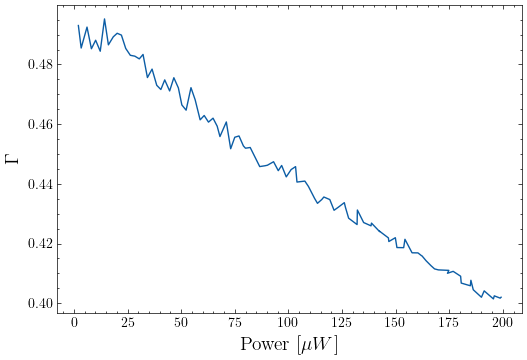

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(data_dict[0]["M_power"][1:], gamma_vals)
ax.set_xlabel(r"Power [$\mu W$]", fontsize=14)
ax.set_ylabel(r"$\Gamma$", fontsize=14)

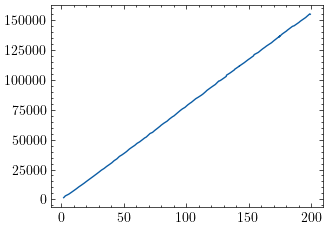

In [15]:
plt.plot(data_dict[0]["M_power"][1:], T_0_vals)

In [13]:
@dataclass
class NLResult:
    coeff: float
    coeff_pow: float
    deriv2: np.ndarray


def calculate_nl_coeff(fit_input: FitInput, fit_result: FitResult) -> np.ndarray:
    linspace = np.linspace(np.min(powerlist), np.max(powerlist), 1000)
    y_fit = fit_input.fit_func(linspace, *fit_result.parameters)
    deriv = np.gradient(y_fit, linspace, edge_order=2)
    deriv2 = np.gradient(deriv, linspace, edge_order=2)
    nl_coeff_idx = np.argmax(deriv2)
    if nl_coeff_idx == 0:
        nl_coeff = 0
    else:
        nl_coeff = deriv2[nl_coeff_idx]
    return NLResult(nl_coeff, linspace[nl_coeff_idx], deriv2)


def pv_power_counts_fit(
    data_dict: dict,
    resistance: int,
    voltages: np.ndarray,
    initial_guesses: list[float],
    softloss: bool = False,
    initial_guesses_feedback: bool = False,
) -> FitResult:
    counts = data_dict[resistance]["counts"]
    power = data_dict[resistance]["M_power"]
    error = np.sqrt(counts)

    fit_inputs = []
    fit_results = []
    nl_results = []
    # nl_coeffs = []
    # nl_idc = []
    # nl_derivs2 = []

    L = 3.5e-3  # Waveguide length in cm
    wl = 2.99792458e5 / 321.5  # Frequency in Thz to wavelength in nm
    T = 298  # Temperature in Kelvin

    for idx, voltage in enumerate(voltages):
    # for idx in range(len(voltages) - 1, -1, -1):
        # voltage = voltages[idx]
        fk_fit = FKFit(power, resistance * 1e-6, L, wl, 0.3, T, voltage)
        fit_func = fk_fit.FK_fit_power_scaled

        if (not initial_guesses_feedback) or (idx == 0):
        # if (not initial_guesses_feedback) or (idx == (len(voltages) - 1)):
            fit_input = FitInput(
                power,
                counts[:, idx],
                error[:, idx],
                fit_func,
                initial_guesses,
                # [0.02, -300, 1000],
            )
        else:
            fit_input = FitInput(
                power,
                counts[:, idx],
                error[:, idx],
                fit_func,
                fit_input.initial_guesses,
            )

        fit_result = perform_fit_rounds(fit_input, opt_rounds=10, softloss=softloss)
        nl_result = calculate_nl_coeff(fit_input, fit_result)

        fit_inputs.append(fit_input)
        fit_results.append(fit_result)
        nl_results.append(nl_result)

        print(fit_result.parameters)

        if not fit_result.success:
            print(
                f"Fit with resistance {resistance} and voltage {voltage} was not completely successful."
            )
    return fit_inputs, fit_results, nl_results
    # return fit_inputs[::-1], fit_results[::-1], nl_results[::-1]

In [14]:
def plot_power_counts_with_fit(inputs, results, voltagelist):

    fig, axs = plt.subplots(3, 3, figsize=(25, 20))

    for idx, ax in enumerate(axs.ravel()):
        ax.set_title(rf"{voltagelist[idx]:.1f} $V$", fontsize=15)
        ax.plot(inputs[idx].xdata, inputs[idx].ydata, ".", label=f"Data")
        linspace = np.linspace(np.min(powerlist), np.max(powerlist), 1000)
        ax.plot(
            linspace,
            inputs[idx].fit_func(linspace, *results[idx].parameters),
            label=f"Fit",
            lw=2,
        )
        ax.legend(frameon=False, fontsize=13)

    fig.text(0.5, 0.06, r"Power [$\mu W$]", ha="center", fontsize=30)
    fig.text(0.09, 0.5, "Counts", va="center", rotation="vertical", fontsize=30)
    plt.show()


def fit_and_plot_for_resistance(
    data_dict: dict,
    voltagelist: np.ndarray,
    resistance: float,
    initial_guesses: list[float],
    softloss=False,
    initial_guesses_feedback=False,
):
    print(f"PLOTS FOR RESISTANCE {resistance:,}")
    fit_inputs, fit_results, nl_results = pv_power_counts_fit(
        data_dict,
        resistance,
        voltagelist,
        initial_guesses,
        softloss=softloss,
        initial_guesses_feedback=initial_guesses_feedback,
    )

    plot_power_counts_with_fit(fit_inputs, fit_results, voltagelist)

    max_derivs = []
    max_nl_power = []

    plt.figure(figsize=(7, 5))
    for idx in range(len(fit_inputs)):
        # input = fit_inputs[idx]
        # output = fit_results[idx]
        nl_result = nl_results[idx]
        # xdata = input.xdata
        # ydata = input.ydata
        linspace = np.linspace(powerlist[0], powerlist[-1], 1000)
        # fit_func = input.fit_func
        # parameters = output.parameters
        # y_fit = fit_func(linspace, *parameters)
        # deriv = np.gradient(np.gradient(y_fit, linspace, edge_order=2), linspace, edge_order=2)
        # nl_coeff_idx = np.argmax(deriv)
        # if nl_coeff_idx == 0:
        #     nl_coeff = 0
        # else:
        #     nl_coeff = deriv[nl_coeff_idx]

        # max_derivs.append(nl_coeff)
        # max_nl_power.append(linspace[nl_coeff_idx])
        # max_derivs_2.append(np.max(deriv) / norm_factor)
        # max_derivs_3.append(np.max(deriv) / norm_factor2)
        max_derivs.append(nl_result.coeff)
        max_nl_power.append(nl_result.coeff_pow)
        plt.plot(linspace, nl_result.deriv2, label=f"{voltagelist[idx]}V")
    plt.xlabel(r"Power [$\mu$W]", fontsize=17)
    plt.ylabel(r"Second derivative of counts", fontsize=17)
    plt.legend()
    plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    ax1.plot(np.abs(voltagelist), max_derivs, ".-")
    ax1.set_xlabel("Reverse bias voltage", fontsize=14)
    ax1.set_ylabel("Non-linearity coefficient", fontsize=14)
    ax2.set_xlabel(r"Reverse bias voltage [$V$]", fontsize=14)
    ax2.set_ylabel("Power at peak non-linearity [$\mu W$]", fontsize=14)
    ax2.plot(np.abs(voltagelist), max_nl_power, ".-")
    plt.show()

    return np.max(max_derivs), voltagelist[np.argmax(max_derivs)]

In [15]:
max_deriv_res = []
max_nl_voltage_res = []

In [25]:
max_deriv, max_nl_voltage = fit_and_plot_for_resistance(data_dict, voltagelist, resistances[0] * 1e-6, [0.04, 40, 997], softloss=True, initial_guesses_feedback=True)
max_deriv_res.append(max_deriv)
max_nl_voltage_res.append(max_nl_voltage)

PLOTS FOR RESISTANCE 0.0
[0.04, 42.07370477548387, 989.0802889959205]
Fit with resistance 0.0 and voltage 0.0 was not completely successful.


KeyboardInterrupt: 

In [49]:
resistance = resistances[0]
voltage_idx = 5
voltage = voltagelist[voltage_idx]
fk_fit = FKFit(data_dict[resistance]["M_power"], resistance * 1e-6, 3.5e-3, 2.99792458e5 / 321.5, 0.3, 298, voltage)
fit_func = fk_fit.FK_fit_power_scaled
lstsq = LeastSquares(data_dict[resistance]["M_power"], data_dict[resistance]["counts"][:, voltage_idx], np.sqrt(data_dict[resistance]["counts"][:, voltage_idx]), fit_func, loss="soft_l1")
minuit_obj = Minuit(lstsq, 0.027914496510214572, 30, 950)
minuit_obj.migrad()
minuit_obj.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1547 (χ²/ndof = 15.9)      │              Nfcn = 251              │
│ EDM = 3.95e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ eta     │ 2.7914e-2 │ 0.0000e-2 │            │            │         │         │       │
│ 1 │ alpha_0 │ -2.9526e2 │ 0.0000e2  │            │            │         │         │       │
│ 2 │ norm    │ 9.5113e2  │ 0.0000e2  │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

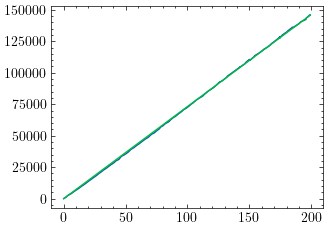

In [45]:
# fk_fit1 = FKFit(data_dict[0]["M_power"], resistances[0], 3.5e-3, 2.99792458e5 / 321.5, 0.3, 298, 0)
# fit_func1 = lambda power, eta, alpha_0: fit_func(power, eta, alpha_0, 1) / np.max(fit_func(power, eta, alpha_0, 1))
# lstsq1 = LeastSquares(data_dict[0]["M_power"], data_dict[0]["counts"][:, 0] / np.max(data_dict[0]["counts"][:, 0]), np.sqrt(data_dict[0]["counts"][:, 0]) / np.max(data_dict[0]["counts"][:, 0]), fit_func1, loss="soft_l1")
# minuit_obj1 = Minuit(lstsq1, 0.02, 200)
# minuit_obj1.migrad()
# minuit_obj1.hesse()
y_fit = fit_func(data_dict[resistance]["M_power"], 0.027914496510214572, 30, 950)
plt.plot(data_dict[0]["M_power"], data_dict[0]["counts"][:, 0])
plt.plot(data_dict[resistance]["M_power"], y_fit)


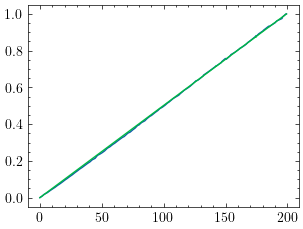

In [118]:
y_fit = fit_func(data_dict[0]["M_power"], 100, -800, 1)
plt.plot(data_dict[0]["M_power"], data_dict[0]["counts"][:, 0] / np.max(data_dict[0]["counts"][:, 0]))
plt.plot(data_dict[0]["M_power"], fit_func1(data_dict[0]["M_power"], 0.01, -500))


Text(0, 0.5, 'Reverse voltage with max non-linearity')

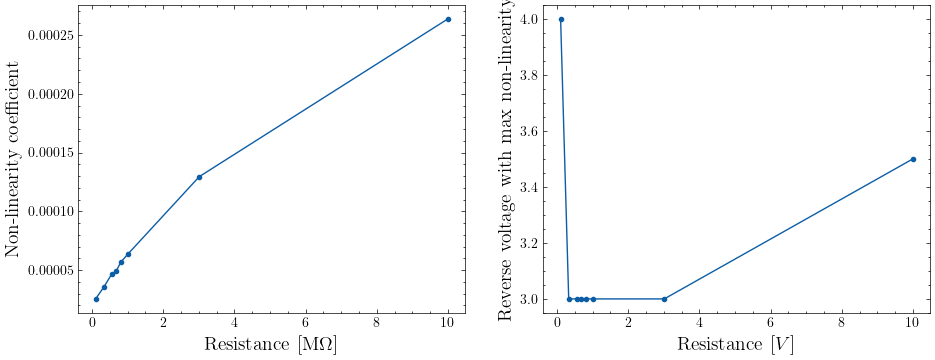

In [10]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
# ax1.plot(np.array(resistances[1:]) * 1e-6, max_deriv_res, '.-')
# ax1.set_xlabel(r"Resistance [M$\Omega$]", fontsize=14)
# ax1.set_ylabel(r"Non-linearity coefficient", fontsize=14)
# ax2.plot(np.array(resistances[1:]) * 1e-6, np.abs(max_nl_voltage_res), '.-')
# ax2.set_xlabel(r"Resistance [$V$]", fontsize=14)
# ax2.set_ylabel(r"Reverse voltage with max non-linearity", fontsize=14)

In [43]:
read_mat(fname)["Data"]["M_freq"]

321.5034416894835